<a href="https://colab.research.google.com/github/NAHIN-JZS/image_colorization/blob/main/pix2pix_image_colorization_on_HSV_actual_for_larger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import cv2
from tensorflow import image

In [ ]:
def define_discriminator(input_image_shape,output_image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=input_image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=output_image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g


In [ ]:
# define the standalone generator model - U-net
def define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,2)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=input_image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('relu')(g)  #Generates hv channel with their actual value
	# define model
	model = Model(in_image, out_image)
	return model


In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
            
	# define the source image
	in_src = Input(shape=input_image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, weight_folder, n_samples=3):
	# select a sample of input images
	
	# save the generator model
	filename2 = weight_folder + '/model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s' % ( filename2))


In [ ]:
# This function will create a list of image path
def generate_image_path_list(folder_name):
  path_list = list() 
  for filename in listdir(folder_name):
    path_list.append(filename)
  return path_list

In [ ]:
import tensorflow as tf
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image, ImageOps

In [ ]:
# load all images in a directory into memory
def load_images(im_indicator, im_path_list, im_path, batch_size, size=(256,256)):
  src_list, tar_list = list(), list()
  if ((im_indicator + batch_size) > len(im_path_list)):
    batch_size = len(im_path_list) - im_indicator
  for j in range(batch_size):
		# load and resize the image
    rgb_image = load_img(im_path + im_path_list[im_indicator + j ], target_size=size)
    rgb_image = img_to_array(rgb_image)
    #convert RGB to HSV
    hsv_pixels = image.rgb_to_hsv(rgb_image)
    # gray_pixels = img_to_array(gray_image)
    gray_pixels = hsv_pixels[:,:,2]
    gray_pixels = np.expand_dims(gray_pixels, axis=2) #increasing the shape from (256,256) to (256,256,1)

    hs_pixels = hsv_pixels[:,:,:2]


		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_pixels)
    tar_list.append(hs_pixels)
  return [asarray(src_list), asarray(tar_list)]

In [ ]:
path = '/content/gdrive/MyDrive/Thesis/Dataset/pascalVOC/JPEGImages/'
weight_folder = '/content/gdrive/MyDrive/Thesis/HSV/PASCAL_VOC/Weight_file'
path_list = generate_image_path_list(path)

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, im_path_list, im_path, weight_folder, save_weight_file_after = 10, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	# trainA, trainB = dataset
	# calculate the number of batches per training epoch
	# bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	# n_steps = bat_per_epo * n_epochs
	
	# manually enumerate epochs
	total_image = len(im_path_list)
	for i in range(n_epochs):
		im_indicator = 0 # Track of current image

		while (im_indicator < total_image):
			dataset  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, batch_size = n_batch);trainA, trainB = dataset
			im_indicator = im_indicator + n_batch

			
			# select a batch of real samples
			[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
			# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
			# update discriminator for real samples
			d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
			# d1_loss.append(d_loss1)
			# update discriminator for generated samples
			d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
			# d2_loss.append(d_loss2)
			# update the generator
			g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
			# summarize performance
			print('>epoch: %d, batch: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1,im_indicator/n_batch, d_loss1, d_loss2, g_loss))
			# summarize model performance
		if (i+1) %  save_weight_file_after == 0:
			summarize_performance(i, g_model, weight_folder)


In [ ]:

#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
# input_image_shape = src_images.shape[1:]
input_image_shape = (256,256,1)
output_image_shape = (256,256,2)
# output_image_shape = tar_images.shape[1:]
# print("Input image shape ",input_image_shape)
# print("Output image shape ",output_image_shape)

# define the models
d_model = define_discriminator(input_image_shape,output_image_shape)
g_model = define_generator(input_image_shape,output_image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, input_image_shape)

#Define data
# load and prepare training images
# dataset = [src_images, tar_images]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:


from datetime import datetime 
start1 = datetime.now() 
print("Start on: ", start1)
train(d_model, g_model, gan_model, im_path_list = path_list, im_path = path, weight_folder = weight_folder, save_weight_file_after = 1, n_epochs=100, n_batch=1)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)




Streaming output truncated to the last 5000 lines.
>epoch: 1, batch: 7718, d1[0.123] d2[0.155] g[21.965]
>epoch: 1, batch: 7719, d1[0.079] d2[0.518] g[20.254]
>epoch: 1, batch: 7720, d1[0.138] d2[0.133] g[25.128]
>epoch: 1, batch: 7721, d1[1.222] d2[0.086] g[25.980]
>epoch: 1, batch: 7722, d1[0.192] d2[0.254] g[22.870]
>epoch: 1, batch: 7723, d1[0.137] d2[0.149] g[21.040]
>epoch: 1, batch: 7724, d1[0.242] d2[0.616] g[23.862]
>epoch: 1, batch: 7725, d1[0.322] d2[0.154] g[15.505]
>epoch: 1, batch: 7726, d1[0.015] d2[0.187] g[34.002]
>epoch: 1, batch: 7727, d1[0.061] d2[0.156] g[24.018]
>epoch: 1, batch: 7728, d1[0.370] d2[0.132] g[18.961]
>epoch: 1, batch: 7729, d1[0.651] d2[0.398] g[10.467]
>epoch: 1, batch: 7730, d1[0.320] d2[0.146] g[14.259]
>epoch: 1, batch: 7731, d1[0.007] d2[0.840] g[45.533]
>epoch: 1, batch: 7732, d1[0.128] d2[0.233] g[15.903]
>epoch: 1, batch: 7733, d1[0.531] d2[0.233] g[32.472]
>epoch: 1, batch: 7734, d1[0.138] d2[0.112] g[26.332]
>epoch: 1, batch: 7735, d1[0.51

In [ ]:
#Test trained model on image...

from keras.models import load_model
from numpy.random import randint
model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint_hsv/model_001528.h5')

In [ ]:
test_data = load_images('/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20056.jpg')


In [ ]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
  
  images = vstack(( gen_img, tar_img))
  #images = src_img
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  pyplot.subplot(1,3,1)
  pyplot.axis('off')
  src_image = np.squeeze(src_img)
  pyplot.imshow(src_image,'gray')
  pyplot.title(titles[0])

  pyplot.subplot(1,3,2)
  pyplot.axis('off')
  # re = np.squeeze(gen_image)
  pyplot.imshow(gen_img,'gray')
  pyplot.title(titles[1])

  pyplot.subplot(1,3,3)
  pyplot.axis('off')
  # re = np.squeeze(tar_image)
  pyplot.imshow(tar_img,'gray')
  pyplot.title(titles[0])

  '''# plot images row by row
  for i in range(len(images)):
    
    # define subplot
    pyplot.subplot(1, 3, 2 + i)# turn off axis
    pyplot.axis('off')# plot raw pixel data
    pyplot.imshow(images[i])# show title
    pyplot.title(titles[i+1])
  print(images.shape)'''
  # pyplot.subplot(1,3,1)
  # pyplot.imshow(images[0,:,:,:])
  pyplot.show()


(256, 256, 2) (256, 256, 1) (256, 256, 2)


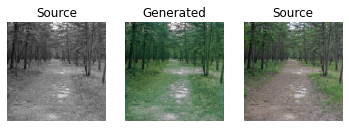

In [ ]:

src_image, tar_image = test_data
# generate image from source
gen_image = model.predict(src_image)

src_image = src_image[0,:,:,:]

gen_image = np.squeeze(gen_image)

gen_hsv = np.concatenate([gen_image,src_image],axis = 2)
gen_rgb = image.hsv_to_rgb(gen_hsv)
gen_rgb = np.array(gen_rgb).astype('uint8')

tar_image = tar_image[0,:,:,:]
print(gen_image.shape,src_image.shape,tar_image.shape)
tar_hsv = np.concatenate([tar_image,src_image],axis = 2)
tar_rgb = image.hsv_to_rgb(tar_hsv)
tar_rgb = np.array(tar_rgb).astype('uint8')

# plot all three images
plot_images(src_image, gen_rgb, tar_rgb)


In [ ]:
re = np.squeeze(src_image)
re.shape

(256, 256)

In [ ]:
src_image.shape

(1, 256, 256, 1)

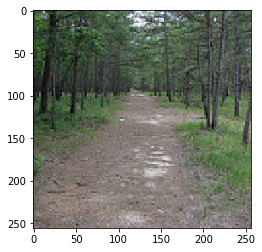

In [ ]:
from tensorflow import image
single_path = '/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20056.jpg'
rgb_image = load_img(single_path, target_size= (256,256))
rgb_image = img_to_array(rgb_image)
# rgb_image = cv2.imread(path)
# print(rgb_image)
# print(rgb_image.shape)
# hsv_pixels = cv2.cvtColor(np.float32(rgb_image), cv2.COLOR_BGR2HSV)
hsv_pixels = image.rgb_to_hsv(rgb_image)

# print(hsv_pixels)
# hsv_pixels = img_to_array(hhh)
# hs = hsv_preprocess_data(hsv_pixels[:,:,:2])

# s = hsv_pixels[:,:,1]
# s = (s - 127.5)/127.5
v = hsv_pixels[:,:,2]
# plt.imshow(v,'gray')

# v = (v - 127.5) /127.5
# h,s,v = cv2.split(hhh)
# h =  np.expand_dims(h, axis=2)
# s =  np.expand_dims(s, axis=2)
v =  np.expand_dims(v, axis=2)
# print(v.shape)
# gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hs = hsv_pixels[:,:,:2]
# print(h.shape,s.shape,v.shape)
# hs = np.array(hs, dtype=np.uint8)
# print(hs)
# v = np.array (v, dtype=np.float32)

# hsv = hsv_post_process(hs,v)
# v = hsv_post_process(v)
# hsv = cv2.merge((hs,v))
# print(hsv.shape)
# hsv = np.array(hsv, dtype=np.uint8)


####output###############
hsv = np.concatenate([hs,v],axis = 2)
# hsv = np.array(hsv).astype('uint8')
rgb = image.hsv_to_rgb(hsv)
# rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
# print(rgb)
rgb = np.array(rgb).astype('uint8')

plt.imshow(rgb,'gray')